# Packages Imports

In [17]:
import os
import random
import zipfile
import json

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()


import tensorflow as tf
import tensorflow_datasets as tfds

from keras.utils import to_categorical
from keras.metrics import MeanIoU, IoU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.models import Model, load_model
from keras.layers import (Input,
                          Activation,
                          MaxPool2D,
                          Concatenate,
                          Conv2D,
                          MaxPooling2D,
                          UpSampling2D,
                          concatenate,
                          Conv2DTranspose,
                          BatchNormalization,
                          Dropout,
                          Lambda)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Datasets Loading

In [18]:
IMG_HEIGHT = 256
IMG_WIDTH  = 256
IMG_CHANNELS = 3
n_classes = 8
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [19]:
# To load the dataset later
dataset = tf.data.Dataset.load('/content/drive/MyDrive/cv_data/train')

# Determine the total size of the dataset
dataset_size = tf.data.Dataset.cardinality(dataset).numpy()

# Define your split ratio (e.g., 80% for training, 20% for validation)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

batch_size = 8

# Split the dataset
dataset_train = dataset.take(train_size).batch(batch_size)
dataset_val = dataset.skip(train_size).batch(batch_size)

In [20]:
for features, labels in dataset_train.take(1):
    # If the dataset is batched, features and labels will have batch dimension as first dimension
    print("Batch size:", features.shape[0])
    print("Feature shape:", features.shape)
    print("Label shape:", labels.shape)
    print("Feature shape per sample:", features.shape[1:])
    print("Label shape per sample:", labels.shape[1:])


Batch size: 8
Feature shape: (8, 256, 256, 3, 1)
Label shape: (8, 256, 256, 1)
Feature shape per sample: (256, 256, 3, 1)
Label shape per sample: (256, 256, 1)


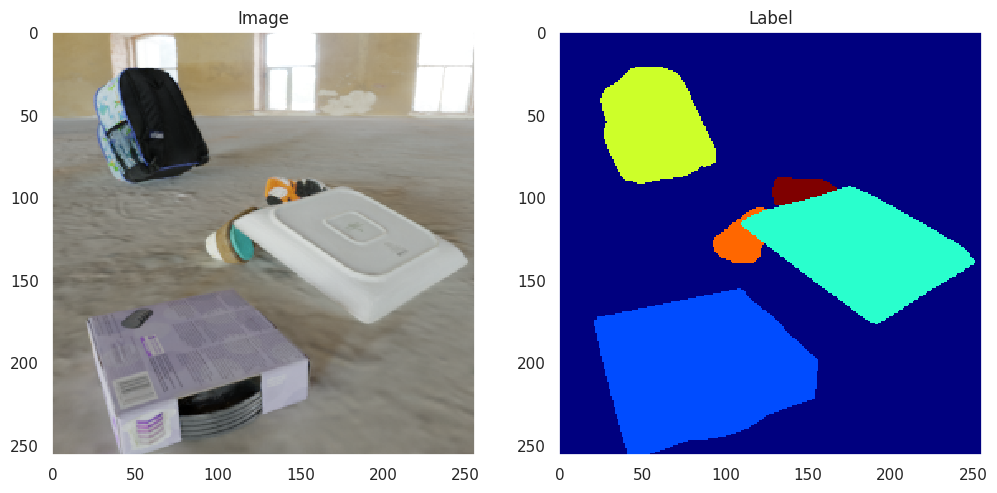

In [5]:
# Take one batch from the dataset
for X_train_batch, y_train_batch in dataset_train.skip(10).take(1):
    img_number = random.randint(0, X_train_batch.shape[0] - 1)

    img = X_train_batch[img_number]
    ground_truth = y_train_batch[img_number]

    # Plotting
    _, axs = plt.subplots(1, 2, figsize=(12, 8))

    plots ={
        "Image": img[..., 0],
        "Label": ground_truth
    }

    for ax, (name, plot) in zip(axs, plots.items()):
        ax.grid(False)
        ax.set_title(name)
        ax.imshow(plot, cmap="jet", interpolation="nearest")

plt.show()


# Labels Preprocessing

Before feeding the data to the model, the labels must be converted to one-hot encoded format. This is need for our model because the labels must be exactly the same as our model's output

In [21]:
# Define a simple mapping function
def preprocess(features, labels):
    # Convert labels to one-hot encoding
    y_cat = tf.one_hot(labels, depth=n_classes)
    y_cat = tf.squeeze(y_cat, axis=-2)

    return features, y_cat

# Apply the mapping function
dataset_train = dataset_train.map(preprocess)
dataset_val = dataset_val.map(preprocess)

In [22]:
print(dataset_train)

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 256, 256, 8), dtype=tf.float32, name=None))>


In [8]:
for features, labels in dataset_val.take(1):
    # If the dataset is batched, features and labels will have batch dimension as first dimension
    print("Batch size:", features.shape[0])
    print("Label shape:", labels.shape)
    print("Feature shape per sample:", features.shape[1:])
    print("Label shape per sample:", labels.shape[1:])


Batch size: 8
Label shape: (8, 256, 256, 8)
Feature shape per sample: (256, 256, 3, 1)
Label shape per sample: (256, 256, 8)


In [9]:
# load the test dataset
dataset_test = tf.data.Dataset.load('/content/drive/MyDrive/cv_data/test')
dataset_test = dataset_test.map(preprocess)
dataset_test = dataset_test.batch(batch_size)

print(dataset_test)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 256, 256, 8), dtype=tf.float32, name=None))>


In [10]:
for features, labels in dataset_test.take(1):
    # If the dataset is batched, features and labels will have batch dimension as first dimension
    print("Batch size:", features.shape[0])
    print("Label shape:", labels.shape)
    print("Feature shape per sample:", features.shape[1:])
    print("Label shape per sample:", labels.shape[1:])


Batch size: 8
Label shape: (8, 256, 256, 8)
Feature shape per sample: (256, 256, 3, 1)
Label shape per sample: (256, 256, 8)


# Model

In order to test the effectiveness of each block of the block of the model. We deleted two blocks from the encoder and two blocks from the decoder and Modifed the bridge and then trained the model again.

In [ ]:
# Building Unet by dividing encoder and decoder into blocks

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   # Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  # Not in the original network
    x = Activation("relu")(x)

    return x


# Encoder block: Conv block followed by maxpooling
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

# Decoder block
# skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

# Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    # s3, p3 = encoder_block(p2, 256)
    # s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p2, 256) # Bridge

    # d1 = decoder_block(b1, s4, 512)
    # d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(b1, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Change the activation based on n_classes
    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'
    print(f"Using {activation} function")

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
model = build_unet(input_shape, n_classes=n_classes)
model.summary()

Using softmax function
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_33 (Conv2D)          (None, 256, 256, 64)         1792      ['input_4[0][0]']             
                                                                                                  
 batch_normalization_30 (Ba  (None, 256, 256, 64)         256       ['conv2d_33[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_30 (Activation)  (None, 256, 256, 64)         0         ['b

# Training

The model was trained in cycles of 20 epochs. This was done to overcome some limitation of colab and it disconnecting every now and then.

In [ ]:
model.load_weights('/content/drive/MyDrive/saved_models/seg_model_ablation.keras')


In [ ]:
def lr_scheduler_fn(epoch, lr):
    # LR to be 0.1 * (1/1+0.01*epoch)
    base_lr = 0.1
    factor = 0.01
    return base_lr / (1 + factor * epoch)

In [ ]:
IoU_metric = IoU(
    num_classes=n_classes,
    sparse_y_true= False,
    sparse_y_pred=False,
    target_class_ids=[0]
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=20,
    mode='min',
    verbose=1
)

lr_scheduler = LearningRateScheduler(lr_scheduler_fn)


epochs = 20

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=["accuracy", IoU_metric]
)

In [ ]:
history = model.fit(
    dataset_train,
    verbose=1,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[early_stopping, lr_scheduler],
    shuffle=False
)

Epoch 1/20
346/346 [==============================] - 167s 450ms/step - loss: 0.0100 - accuracy: 0.9963 - io_u_5: 0.9967 - val_loss: 0.2630 - val_accuracy: 0.9604 - val_io_u_5: 0.9667
Epoch 2/20
346/346 [==============================] - 153s 440ms/step - loss: 0.0065 - accuracy: 0.9975 - io_u_5: 0.9976 - val_loss: 0.2040 - val_accuracy: 0.9676 - val_io_u_5: 0.9714
Epoch 3/20
346/346 [==============================] - 153s 439ms/step - loss: 0.0069 - accuracy: 0.9974 - io_u_5: 0.9975 - val_loss: 0.2402 - val_accuracy: 0.9652 - val_io_u_5: 0.9689
Epoch 4/20
346/346 [==============================] - 148s 428ms/step - loss: 0.0221 - accuracy: 0.9925 - io_u_5: 0.9939 - val_loss: 0.1913 - val_accuracy: 0.9615 - val_io_u_5: 0.9663
Epoch 5/20
346/346 [==============================] - 152s 439ms/step - loss: 0.0085 - accuracy: 0.9968 - io_u_5: 0.9970 - val_loss: 0.1979 - val_accuracy: 0.9657 - val_io_u_5: 0.9688
Epoch 6/20
346/346 [==============================] - 148s 428ms/step - loss: 0.

In [ ]:
# Save the model for future use
model.save('/content/drive/MyDrive/saved_models/seg_model_ablation.keras')

In [ ]:
# NOTICE: Only run this cell once otherwise, you will concatenate the results multiple times
with open("/content/drive/MyDrive/results/ablation_train_results.json", 'r') as results_file:
    results = json.load(results_file)

results["loss"]["train"].extend(history.history['loss'])
results["loss"]["val"].extend(history.history['val_loss'])
results["accuracy"]["train"].extend(history.history['accuracy'])
results["accuracy"]["val"].extend(history.history['val_accuracy'])

with open("/content/drive/MyDrive/results/ablation_train_results.json", 'w') as results_file:
    json.dump(results, results_file)

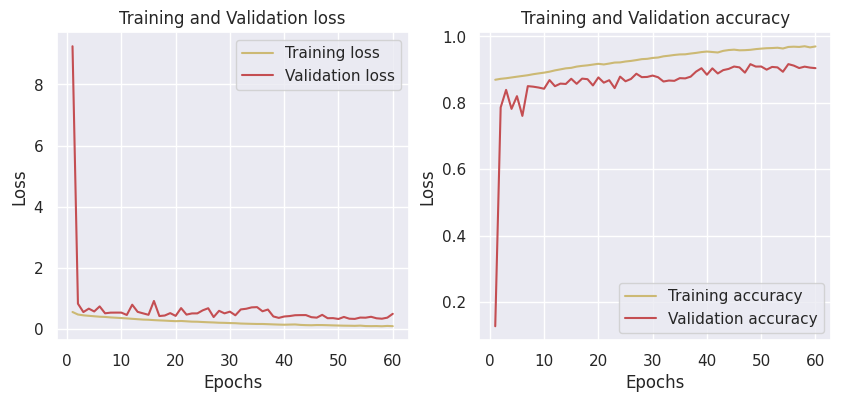

In [15]:
# plot the training and validation accuracy and loss at each epoch

_, axs = plt.subplots(1, 2, figsize=(10, 4))


for ax, metric in zip(axs, results.keys()):
    epochs = range(1, len(results[metric]["train"]) + 1)
    ax.plot(epochs, results[metric]["train"], 'y', label=f'Training {metric}')
    ax.plot(epochs, results[metric]["val"], 'r', label=f'Validation {metric}')

    ax.legend()
    ax.set_title(f'Training and Validation {metric}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')

plt.show()